In [2]:
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Test of the Poisson equation with known solution

In [2]:
n = 127
A = gallery.poisson((n, n))
print(A.shape)

16129


In [3]:
linear_gmg = gmg_linear.LinearGMG(A, max_levels=4)
print(linear_gmg)
print("Spectral radius = {}".format(linear_gmg.compute_rho()))

Dimension of matrix A for levels:
Level = 0, dimension = (15, 15)
Level = 1, dimension = (31, 31)
Level = 2, dimension = (63, 63)
Level = 3, dimension = (127, 127)

Spectral radius = 0.197411905865484


(128,)
(127, 127)
(16129, 1)
(16129, 1)
2.2559205562503345e-11
5.0200915919009535e-05


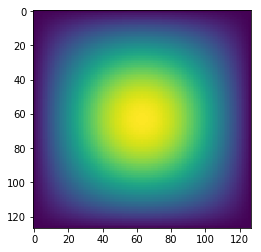

In [4]:
x0 = np.random.randn(A.shape)
x = np.linspace(0, 1, num=n+1, endpoint=False)
y = np.linspace(0, 1, num=n+1, endpoint=False)
print(x.shape)
xx, yy = np.meshgrid(x[1:], y[1:])
print(xx.shape)
x_true = np.sin(np.pi * xx) * np.sin(np.pi * yy)
rhs = 2 * np.pi**2 * x_true / (n+1)**2
plt.imshow(rhs)
rhs = rhs.reshape(A.shape, 1)
print(rhs.shape)
x = linear_gmg.solve(rhs, x0, tol=1e-10)
print(x.shape)
print(np.linalg.norm(A.dot(x) - rhs))
print(np.linalg.norm(x - x_true.reshape(A.shape, 1)) / np.linalg.norm(x_true.reshape(A.shape, 1)))

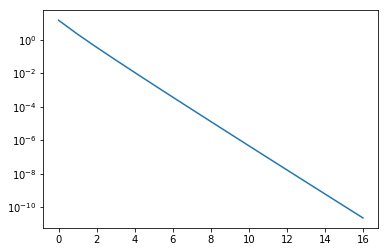

In [5]:
plt.semilogy(linear_gmg.get_gmg_convergence())

In [6]:
x = x.reshape(A.dim)
print(x.shape)

(127, 127)


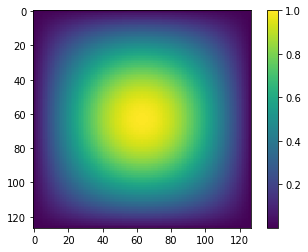

In [7]:
plt.imshow(x)
plt.colorbar()

## Study dependance $\rho$ on dimension in 1D and 2D case and optimize it

### 1D

In [8]:
num_levels = 2
ns = [2**i - 1 for i in range(3, 8)]
rhos_linear = []
print("Test dims: {}".format(ns))
for n in ns:
    print("Current dim = {}".format(n))
    A = gallery.poisson((n, ))
    linear_gmg = gmg_linear.LinearGMG(A, max_levels=num_levels)
    rhos_linear.append(linear_gmg.compute_rho())

Test dims: [7, 15, 31, 63, 127]
Current dim = 7
Current dim = 15
Current dim = 31
Current dim = 63
Current dim = 127


Text(0,0.5,'Spectral radius')

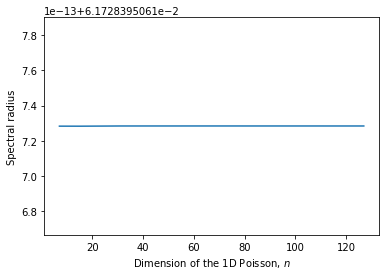

In [9]:
plt.plot(ns, rhos_linear)
plt.xlabel("Dimension of the 1D Poisson, $n$")
plt.ylabel("Spectral radius")

In [10]:
rhos_opt = []
K = 20
batch_size = 10
num_iter = 2500
step_size = 5e-5
PR_stencil_type = "3p"
init_point = None
convergence = {}
opt_par_n = {}
conv_time = {}
for n in ns:
    print("Current dim = {}".format(n))
    A = gallery.poisson((n, ))
    deep_gmm = dgmg.DeepMG(A, K=K, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
    opt_par = deep_gmm.optimize(num_iter=num_iter, step_size=step_size, batch_size=batch_size, init_point=init_point)
    opt_par_n[n] = opt_par
    convergence[n] = deep_gmm.get_optimizer_convergence()
    conv_time[n] = deep_gmm.get_optimization_time()
    deep_gmm.update_prd(opt_par)
    current_rho = deep_gmm.compute_rho()
    rhos_opt.append(current_rho)
    print("Optimized rho = {}".format(current_rho))

Current dim = 7
Iteration 100/2500
Upper bound estimation = 0.05417441305001503
Iteration 200/2500
Upper bound estimation = 0.047567105673561594
Iteration 300/2500
Upper bound estimation = 0.04090516242738831
Iteration 400/2500
Upper bound estimation = 0.0339936441133787
Iteration 500/2500
Upper bound estimation = 0.028788662940213844
Iteration 600/2500
Upper bound estimation = 0.02656852576692476
Iteration 700/2500
Upper bound estimation = 0.025112959561428904
Iteration 800/2500
Upper bound estimation = 0.024663088423693007
Iteration 900/2500
Upper bound estimation = 0.023574631769062045
Iteration 1000/2500
Upper bound estimation = 0.022784963068116854
Iteration 1100/2500
Upper bound estimation = 0.021945587896216062
Iteration 1200/2500
Upper bound estimation = 0.02113720421771446
Iteration 1300/2500
Upper bound estimation = 0.020156180605681077
Iteration 1400/2500
Upper bound estimation = 0.01930647058804824
Iteration 1500/2500
Upper bound estimation = 0.018445492964483355
Iteration 

Iteration 2400/2500
Upper bound estimation = 0.03312212145949239
Iteration 2500/2500
Upper bound estimation = 0.032419327087057234
Optimized rho = 0.030996207634861914


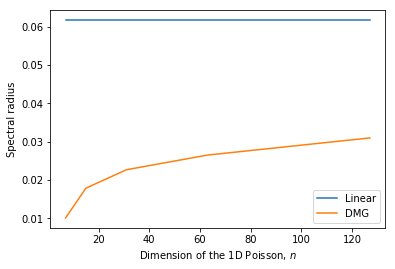

In [11]:
plt.plot(ns, rhos_linear, label="Linear")
plt.plot(ns, rhos_opt, label="DMG")
plt.xlabel("Dimension of the 1D Poisson, $n$")
plt.ylabel("Spectral radius")
plt.legend()

### 2D

In [8]:
num_levels = 4
ns = [2**i - 1 for i in range(3, 8)]
rhos_linear = []
rhos_amg = []
print("Test dims: {}".format(ns))
for n in ns:
    print("Current dim = {}".format(n))
    A = gallery.poisson((n, n))
    linear_gmm = gmg_linear.LinearGMG(A, max_levels=num_levels)
    current_rho = linear_gmm.compute_rho()
    print("Linear spectral radius = {}".format(current_rho))
    rhos_linear.append(current_rho)
    amg = classical_amg.ClassicalAMG(A, num_levels)
    current_rho = amg.compute_rho()
    print("AMG spectral radius = {}".format(current_rho))
    rhos_amg.append(current_rho)

Test dims: [7, 15, 31, 63, 127]
Current dim = 7
Linear spectral radius = 0.1691322702974944
AMG spectral radius = 0.09117489460224734
Current dim = 15
Linear spectral radius = 0.19004855909337043
AMG spectral radius = 0.10991720305651467
Current dim = 31
Linear spectral radius = 0.19563539315324527
AMG spectral radius = 0.12374172183023358
Current dim = 63
Linear spectral radius = 0.1970554247753588
AMG spectral radius = 0.16366864639939538
Current dim = 127
Linear spectral radius = 0.19741190586548463
AMG spectral radius = 0.2635446473868652


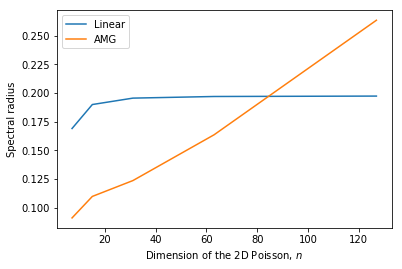

In [9]:
plt.plot(ns, rhos_linear, label="Linear")
plt.plot(ns, rhos_amg, label="AMG")
plt.xlabel("Dimension of the 2D Poisson, $n$")
plt.ylabel("Spectral radius")
plt.legend()

In [ ]:
rhos_opt = []
K = 10
batch_size = 30
num_iter = 2000
step_size = 1e-4
PR_stencil_type = "m9p"
init_point = None
convergence = {}
opt_par_n = {}
conv_time = {}
for n in ns:
    print("Current dim = {}".format(n))
    A = gallery.poisson((n, n))
    gmm = dgmg.DeepMG(A, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
    opt_par = gmm.optimize(num_iter=num_iter, step_size=step_size)
    opt_par_n[n] = opt_par
    convergence[n] = gmm.get_optimizer_convergence()
    conv_time[n] = gmm.get_optimization_time()
    gmm.update_prd(opt_par)
    current_rho = gmm.compute_rho()
    rhos_opt.append(current_rho)
    print("Optimized rho = {}".format(current_rho))
if init_point:
    init_type = "random"
else:
    init_type = "linear"

Current dim = 7
Iteration 100/2000
Upper bound estimation = 0.17096937021502828
Iteration 200/2000
Upper bound estimation = 0.1622795083642141
Iteration 300/2000
Upper bound estimation = 0.1593256197005634
Iteration 400/2000
Upper bound estimation = 0.15134503611169092
Iteration 500/2000
Upper bound estimation = 0.1459959732824815
Iteration 600/2000
Upper bound estimation = 0.1401124908828632
Iteration 700/2000
Upper bound estimation = 0.1306968013302596
Iteration 800/2000
Upper bound estimation = 0.12836043864655725
Iteration 900/2000
Upper bound estimation = 0.10968534774443464
Iteration 1000/2000
Upper bound estimation = 0.10271298478376077
Iteration 1100/2000
Upper bound estimation = 0.08900659866484707
Iteration 1200/2000
Upper bound estimation = 0.08416590078974565
Iteration 1300/2000
Upper bound estimation = 0.08163359733351112
Iteration 1400/2000
Upper bound estimation = 0.07863942409925524
Iteration 1500/2000
Upper bound estimation = 0.0757911878812446
Iteration 1600/2000
Uppe

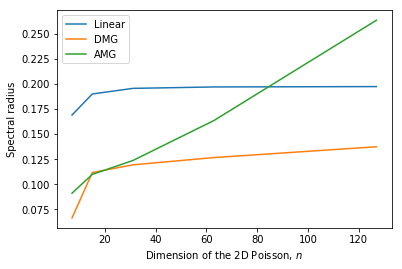

In [15]:
plt.plot(ns, rhos_linear, label="Linear")
plt.plot(ns, rhos_opt, label="DMG")
plt.plot(ns, rhos_amg, label="AMG")
plt.xlabel("Dimension of the 2D Poisson, $n$")
plt.ylabel("Spectral radius")
plt.legend()

In [28]:
n=7
A = gallery.poisson((n,n))
PR_stencil_type = "m9p"
gmm = dgmg.DeepMG(A, PR_stencil_type=PR_stencil_type, max_levels=2)
num_iter = 10
step_size = 0.001
opt_par = gmm.optimize(num_iter=num_iter, step_size=step_size)

In [29]:
print(opt_par[0])

[array([[[[0.24457769, 0.50698117, 0.25974036],
         [0.49012182, 0.9904389 , 0.50985345],
         [0.23995144, 0.49360353, 0.25906135]],

        [[0.25978772, 0.50976227, 0.25974262],
         [0.49802292, 0.99037045, 0.50846232],
         [0.24032413, 0.49016923, 0.24012625]],

        [[0.26002547, 0.50992251, 0.25889757],
         [0.50992881, 0.99049395, 0.49011061],
         [0.24182733, 0.49000549, 0.23985804]]],


       [[[0.23999453, 0.50947774, 0.25981606],
         [0.49001496, 0.99048165, 0.50997105],
         [0.2400503 , 0.49058721, 0.26007809]],

        [[0.23985279, 0.48984789, 0.25945263],
         [0.48990007, 0.99039488, 0.51011097],
         [0.25950734, 0.51006493, 0.26005846]],

        [[0.25995942, 0.50571213, 0.2502778 ],
         [0.50489038, 0.99032833, 0.4958647 ],
         [0.25612397, 0.49760049, 0.2477607 ]]],


       [[[0.26003245, 0.50485844, 0.24091721],
         [0.50993789, 0.99025117, 0.49007134],
         [0.25928734, 0.49506252, 0.2399343

[[0.25 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.5  0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.25 0.25 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.5  0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.25 0.25 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.5  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.25 0.   0.   0.   0.   0.   0.  ]
 [0.5  0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.5  0.5  0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.5  0.5  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.5  0.   0.   0.   0.   0.   0.  ]
 [0.25 0.   0.   0.25 0.   0.   0.   0.   0.  ]
 [0.5  0.   0.   0.5  0.   0.   0.   0.   0.  ]
 [0.25 0.25 0.   0.25 0.25 0.   0.   0.   0.  ]
 [0.   0.5  0.   0.   0.5  0.   0.   0.   0.  ]
 [0.   0.25 0.25 0.   0.25 0.25 0.   0.   0.  ]
 [0.   0.   0.5  0.   0.   0.5  0.   0.   0.  ]
 [0.   0.   0.25 0.   0.   0.25 0.   0. 

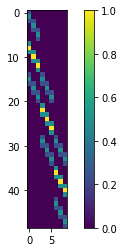

In [82]:
P = opt_par[0][0]
k = int(2**(np.log2(n+1)-1)-1) 
P_Matrix = np.zeros([n**2,k**2])
for i in range(k):
    for j in range(k):
        C = P[i][j]
        for l in range(3):
            for m in range(3):
                P_Matrix[n*(2*i+l)+(2*j+m)][k*i+j] = C[l][m]
print(P_Matrix)
plt.imshow(P_Matrix)
plt.colorbar() 

In [84]:
R = opt_par[1][0]

In [85]:
print(R)

[[[[0.0625 0.125  0.0625]
   [0.125  0.25   0.125 ]
   [0.0625 0.125  0.0625]]

  [[0.0625 0.125  0.0625]
   [0.125  0.25   0.125 ]
   [0.0625 0.125  0.0625]]

  [[0.0625 0.125  0.0625]
   [0.125  0.25   0.125 ]
   [0.0625 0.125  0.0625]]]


 [[[0.0625 0.125  0.0625]
   [0.125  0.25   0.125 ]
   [0.0625 0.125  0.0625]]

  [[0.0625 0.125  0.0625]
   [0.125  0.25   0.125 ]
   [0.0625 0.125  0.0625]]

  [[0.0625 0.125  0.0625]
   [0.125  0.25   0.125 ]
   [0.0625 0.125  0.0625]]]


 [[[0.0625 0.125  0.0625]
   [0.125  0.25   0.125 ]
   [0.0625 0.125  0.0625]]

  [[0.0625 0.125  0.0625]
   [0.125  0.25   0.125 ]
   [0.0625 0.125  0.0625]]

  [[0.0625 0.125  0.0625]
   [0.125  0.25   0.125 ]
   [0.0625 0.125  0.0625]]]]


In [86]:
k = int(2**(np.log2(n+1)-1)-1) 
R_Matrix = np.zeros([k**2,n**2])

print(R_Matrix)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  

[[0.0625 0.125  0.0625 0.     0.     0.     0.     0.125  0.25   0.125
  0.     0.     0.     0.     0.0625 0.125  0.0625 0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.0625 0.125  0.0625 0.     0.     0.     0.     0.125
  0.25   0.125  0.     0.     0.     0.     0.0625 0.125  0.0625 0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.0625 0.125  0.0625 0.     0.     0.
  0.     0.125  0.25   0.125  0.     0.     0.     0.     0.0625 0.125
  0.0625 0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    

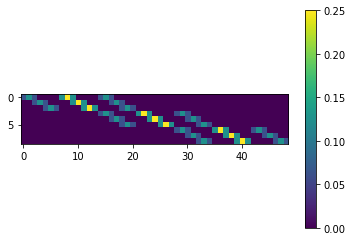

In [88]:
for i in range(k):
    for j in range(k):
        C = R[i][j]
        for l in range(3):
            for m in range(3):
                R_Matrix[k*i+j][n*(2*i+l)+(2*j+m)] = C[l][m]
print(R_Matrix)
plt.imshow(R_Matrix)
plt.colorbar() 